# 30. Расширенный вариационный автоэнкодер (CVAE)

In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow import keras
#import keras.backend as K
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Lambda, BatchNormalization, Dropout
from tensorflow.keras.layers import concatenate

2024-11-19 22:05:23.705614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 22:05:23.864288: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 22:05:23.911080: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
hidden_dim = 2
num_classes = 10
batch_size = 100 #должно быть кратно 60 000  или 10 0000

(x_train, y_train), (x_test, y_test) = mnist.load_data()

#стандартизация данных
x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [3]:
def dropout_and_batch(x):
    return Dropout(0.3)(BatchNormalization()(x))

input_img = Input(shape=(28, 28, 1))
fl = Flatten()(input_img)
lb = Input(shape=(num_classes,))
x = concatenate([fl, lb])
x = Dense(256, activation='relu')(x)
x = dropout_and_batch(x)
x = Dense(128, activation='relu')(x)
x = dropout_and_batch(x)

z_mean2 = Dense(hidden_dim)(x)
z_log_var = Dense(hidden_dim)(x)

def noiser(args):
    global z_mean, z_log_var
    z_mean, z_log_var = args
    N = K.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
    
    return K.exp(z_log_var / 2) * N +z_mean


In [4]:
h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean2, z_log_var])

input_dec = Input(shape=(hidden_dim,))
lb_dec = Input(shape=(num_classes,))
d = concatenate([input_dec, lb_dec])
d = Dense(128, activation='elu')(d)
d = dropout_and_batch(d)
d = Dense(256, activation='elu')(d)
d = dropout_and_batch(d)
d = Dense(28*28, activation='sigmoid')(d)
decoded = Reshape((28, 28, 1))(d)

encoder = keras.Model([input_img, lb], h, name='encoder')
decoder = keras.Model([input_dec, lb_dec], decoded, name='decoder')
cvae = keras.Model([input_img, lb, lb_dec], decoder([encoder([input_img, lb]), lb_dec]), name="cvae")

z_meaner = keras.Model([input_img, lb], z_mean2)
tr_style = keras.Model([input_img, lb, lb_dec], decoder([z_meaner([input_img, lb]), lb_dec]), name='tr_style')

In [5]:
def vae_loss(x, y):
    x = K.reshape(x, shape=(batch_size, 28*28))
    y = K.reshape(y, shape=(batch_size, 28*28))
    loss = K.sum(K.square(x-y), axis= -1)
    kl_loss = -0.5*K.sum(1+z_log_var - K.square(z_mean) - K.exp(z_log_var), axis= -1)
    return (loss + kl_loss)/2/28/28

cvae.compile(optimizer='adam', loss=vae_loss)

In [6]:
cvae.fit([x_train, y_train_cat, y_train_cat], x_train, epochs=5, batch_size=batch_size, shuffle=True)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0652
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0243
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0235
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0229
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0228


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


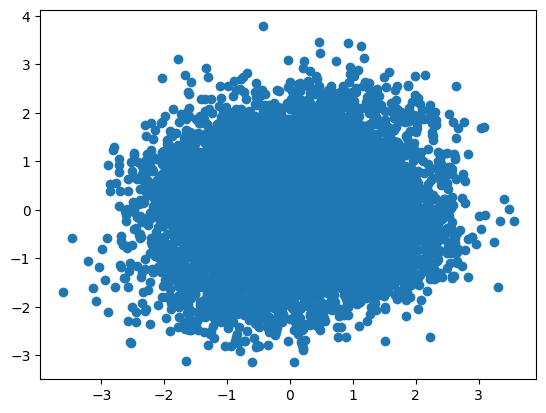

In [11]:
lb = lb_dec = y_test_cat
h = encoder.predict([x_test, lb], batch_size=batch_size)
plt.scatter(h[:, 0], h[:, 1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

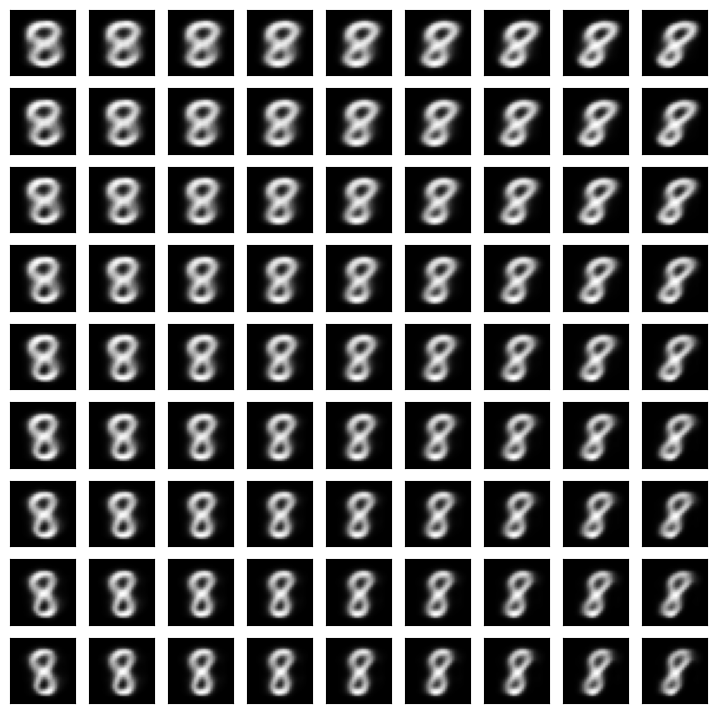

In [16]:
n = 4
total = 2*n+1
input_lbl = np.zeros((1, num_classes))
input_lbl[0, 8] = 1

plt.figure(figsize=(total, total))

h = np.zeros((1, hidden_dim))
num = 1
for i in range(-n, n+1):
    for j in range(-n, n+1):
        ax = plt.subplot(total, total, num)
        num += 1
        h[0, :] = [1*i / n, 1*j / n]
        img = decoder.predict([h, input_lbl])
        plt.imshow(img.squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


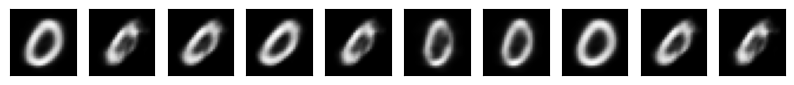

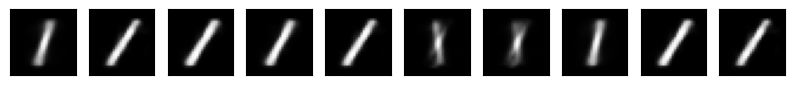

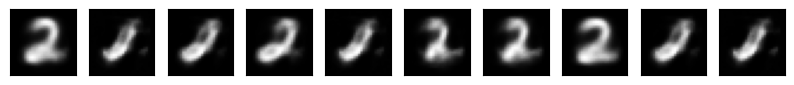

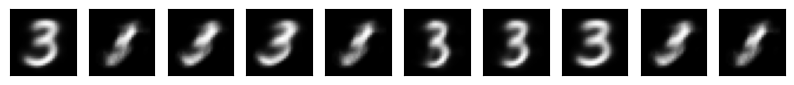

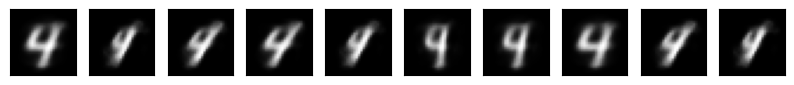

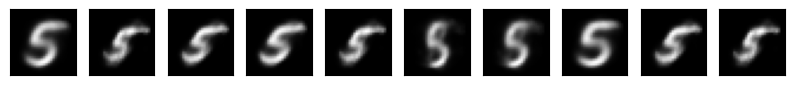

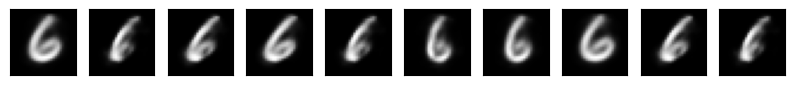

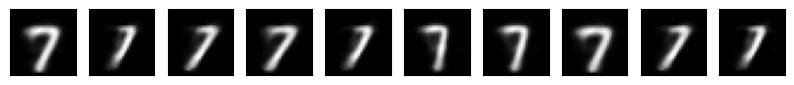

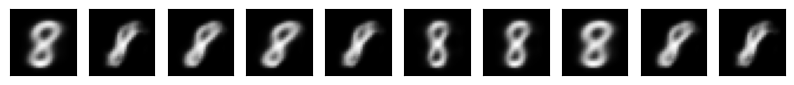

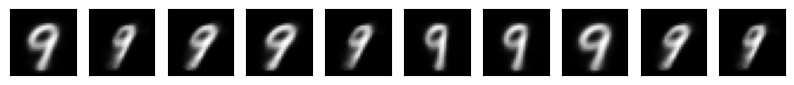

In [17]:
def plot_digits(*images):
    images = [x.squeeze() for x in images]
    n = min([x.shape[0] for x in images])
    
    plt.figure(figsize=(n, len(images)))
    for j in range(n):
        for i in range(len(images)):
            ax = plt.subplot(len(images), n, i*n + j + 1)
            plt.imshow(images[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show
    
dig1 = 5
dig2 = 2

num = 10
X = x_train[y_train == dig1][:num]

lb_1 = np.zeros((num, num_classes))
lb_1[:, dig1] = 1

for i in range(num_classes):
    lb_2 = np.zeros((num, num_classes))
    lb_2[:, i] = 1
    
    Y = tr_style.predict([X, lb_1, lb_2], batch_size=num)
    plot_digits(Y)